# Regression Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from linearReg import LinearReg
from gdOptimizers import GDOptimizers

### Setup of data

In [2]:
def franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
def data(n = 100):
    x = np.random.rand(n) #an array of n unordered uniform random numbers from 0 to 1
    y = np.random.rand(n)
    xy = np.column_stack((x, y))
    
    noise = np.random.randn(n) / 10
    z = np.array([franke(x, y) + noise]).T
    return xy, z

In [4]:
xy, z = data(100)
xy_train, xy_test, z_train, z_test = train_test_split(xy, z, test_size = 0.2)

(100, 1)


### FFNN

In [5]:
from FFNN import FFNN

nn = FFNN(inputs = 2)
nn.addLayer(neurons = 5, activation = "sigmoid")
nn.addLayer(neurons = 1, activation = "linear")

sgd = GDOptimizers(learning_rate = 0.00005, epochs = 1000, batch_size = 10, optimizer = "momentum")
nn.compile(loss="mse", optimizer=sgd, lmda = 0.01)

Mean squared error on training data = 0.1436
Mean squared error = 0.1903


In [6]:
z_mdl = nn.predict(xy_test)
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")
z_mdl = nn.predict(xy_train)
print(f"Mean squared error on training data = {mean_squared_error(z_mdl, z_train):.4f}")

z_train_mdl = nn.fit(xy_train, z_train)
z_mdl = nn.predict(xy_test)

print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error = 3.3573
Mean squared error on training data = 3.3528
Mean squared error on training data = 0.2215
Mean squared error = 0.2081


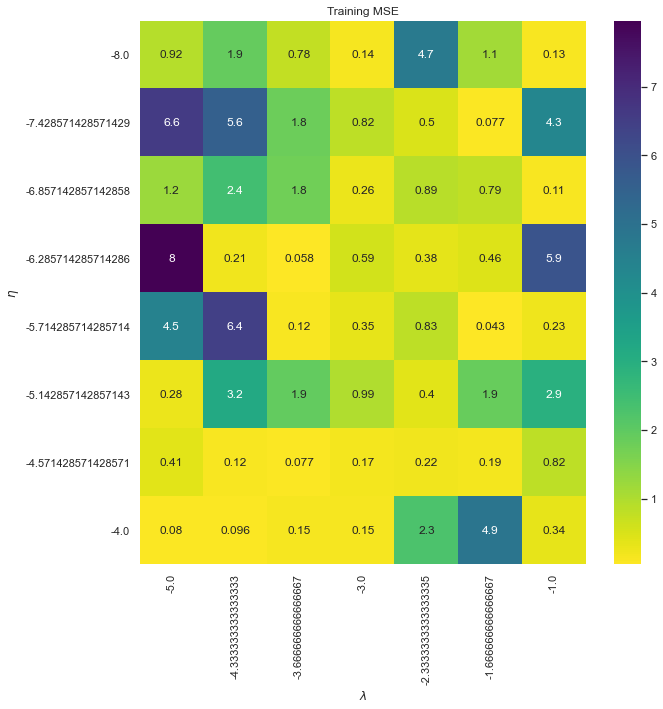

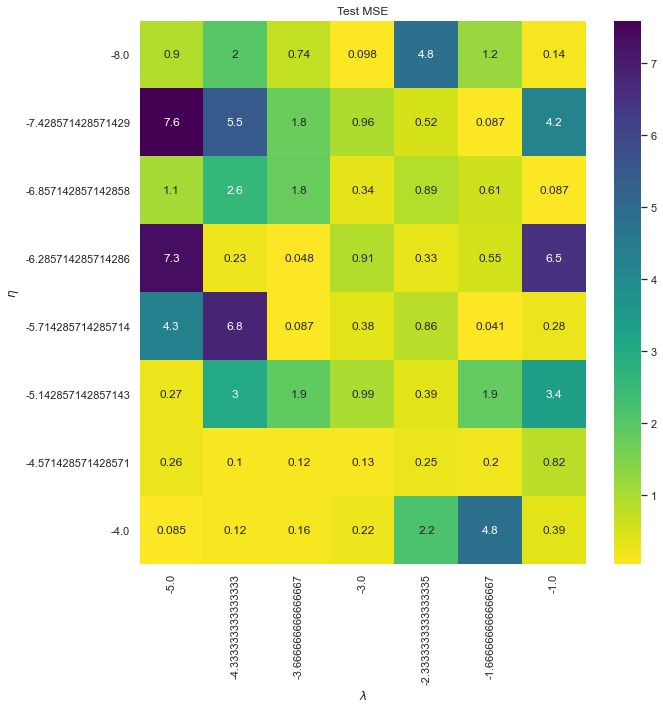

In [17]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns

sns.set()

eta_vals = np.logspace(-8, -4, 8)
lmbd_vals = np.logspace(-5, -1, 7)
train_mse = np.zeros((len(eta_vals), len(lmbd_vals)))
test_mse = np.zeros((len(eta_vals), len(lmbd_vals)))

for i, eta in enumerate(eta_vals):
    for j, lmda in enumerate(lmbd_vals):
        nn = FFNN(inputs = 2)
        nn.addLayer(neurons = 5, activation = "sigmoid")
        nn.addLayer(neurons = 1, activation = "linear")

        sgd = GDOptimizers(learning_rate = eta, epochs = 1000, batch_size = 10, optimizer = "SGD")
        nn.compile(loss="mse", optimizer=sgd, lmda = lmda)
        
        z_train_mdl = nn.fit(xy_train, z_train)
        z_mdl = nn.predict(xy_test)

        train_mse[i][j] = mean_squared_error(z_train_mdl, z_train)
        test_mse[i][j] = mean_squared_error(z_mdl, z_test)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_mse, annot=True, ax=ax, cmap="viridis_r", xticklabels=np.log10(lmbd_vals), yticklabels=np.log10(eta_vals))
ax.set_title("Training MSE")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_mse, annot=True, ax=ax, cmap="viridis_r", xticklabels=np.log10(lmbd_vals), yticklabels=np.log10(eta_vals))
ax.set_title("Test MSE")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

### Ridge regression with SGD

In [7]:
model = LinearReg(order = 3, lmda = 1E-5)
sgd = GDOptimizers(learning_rate = 0.01, epochs = 1000, batch_size = 10, optimizer = "SGD")
z_mdl = model.predict(xy_test)
print(f"Mean squared error before fit = {mean_squared_error(z_mdl, z_test):.4f}")

z_train_mdl = model.fit(xy_train, z_train, sgd)

z_mdl = model.predict(xy_test)
print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error before fit = 3.8289
Mean squared error on training data = 0.0196
Mean squared error = 0.0248


In [8]:
model = LinearReg(order = 3, lmda = 1E-5)
momentum = GDOptimizers(learning_rate = 0.01, epochs = 1000, batch_size = 10, optimizer = "momentum", alpha=0.5)
z_train_mdl = model.fit(xy_train, z_train, momentum)

z_mdl = model.predict(xy_test)
print(f"Mean squared error on training data = {mean_squared_error(z_train_mdl, z_train):.4f}")
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error on training data = 0.0163
Mean squared error = 0.0229


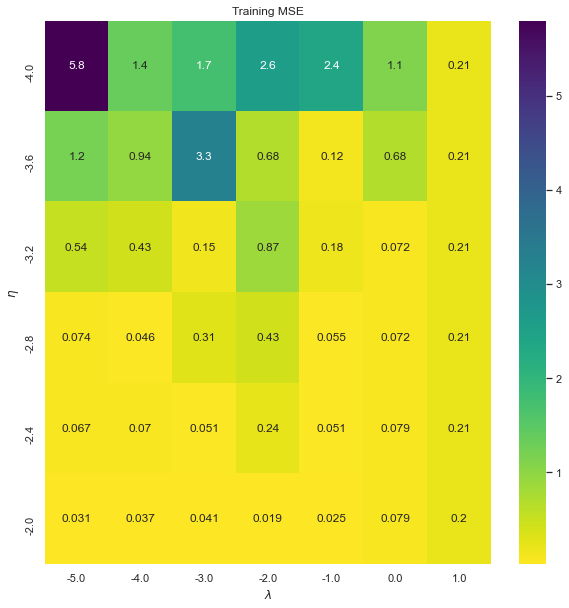

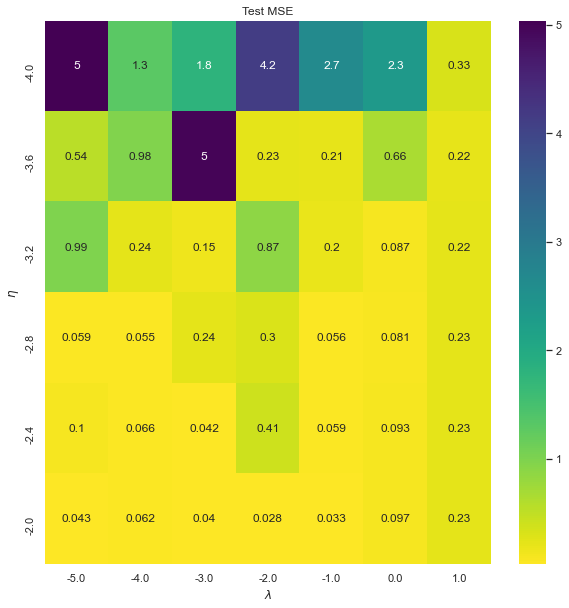

In [9]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns

sns.set()

eta_vals = np.logspace(-4, -2, 6)
lmbd_vals = np.logspace(-5, 1, 7)
train_mse = np.zeros((len(eta_vals), len(lmbd_vals)))
test_mse = np.zeros((len(eta_vals), len(lmbd_vals)))

for i, eta in enumerate(eta_vals):
    for j, lmda in enumerate(lmbd_vals):
        model = LinearReg(order = 3, lmda = lmda)
        sgd = GDOptimizers(learning_rate = eta, epochs = 100, batch_size = 10, optimizer = "SGD")
        
        z_train_mdl = model.fit(xy_train, z_train, sgd)
        z_mdl = model.predict(xy_test)

        train_mse[i][j] = mean_squared_error(z_train_mdl, z_train)
        test_mse[i][j] = mean_squared_error(z_mdl, z_test)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_mse, annot=True, ax=ax, cmap="viridis_r", xticklabels=np.log10(lmbd_vals), yticklabels=np.log10(eta_vals))
ax.set_title("Training MSE")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_mse, annot=True, ax=ax, cmap="viridis_r", xticklabels=np.log10(lmbd_vals), yticklabels=np.log10(eta_vals))
ax.set_title("Test MSE")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

### Regression with Tensorflow

In [14]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

from sklearn.model_selection import train_test_split

In [66]:
model = Sequential()
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1))

eta = 0.001
sgd = optimizers.SGD(lr=eta)
model.compile(loss='mse', optimizer=sgd, metrics=['mse'])

z_mdl = model.predict(xy_test)
print(f"Mean squared error before fit = {mean_squared_error(z_mdl, z_test):.4f}")

model.fit(xy_train, z_train, epochs=1000, batch_size=10, verbose=0)
#scores = model.evaluate(xy_test, z_test)

z_mdl = model.predict(xy_test)
print(f"Mean squared error = {mean_squared_error(z_mdl, z_test):.4f}")

Mean squared error before fit = 0.7202
Mean squared error = 0.0920
